In [24]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import display, Math
import warnings
warnings.simplefilter('ignore')

## Simulate estimation with artifical data

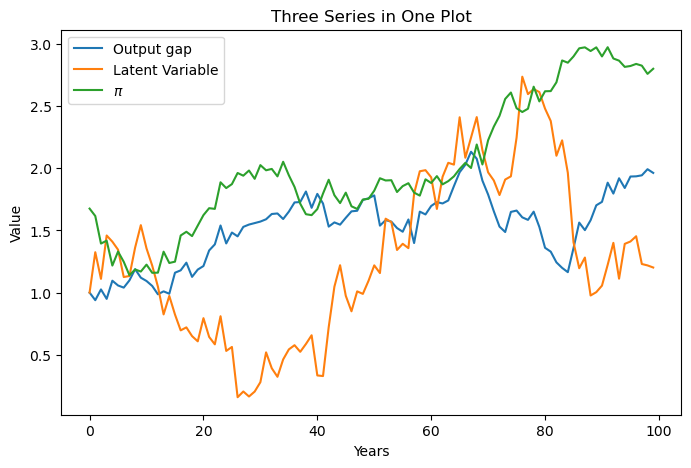

In [ ]:
# Loading data (Now, simulatio data)
T = 100
sigma_eta = 0.2
beta_true  =  0.988
kappa_true = 0.016
alpha_true = 0.02

initial_Epi = 1.7
initial_gap = 1
initial_z   = 1
initial_pi  = beta_true * initial_Epi + kappa_true * initial_gap - alpha_true * initial_z

pi = [initial_pi]
Epi = [initial_Epi]
gap = [initial_gap]
z = [initial_z]

np.random.seed(1)
for t in range(1, T):
    # Latent Variable
    z.append(z[t-1] + np.random.normal(0, sigma_eta))
    # Output gap
    gap.append(gap[t-1] + np.random.normal(0, 0.1))
    # Expectation of inflation (Epi)
    Epi.append(Epi[t-1] + np.random.normal(0, 0.1))
    # Inflation (pi)
    pi.append(beta_true * Epi[t] + kappa_true * gap[t] - alpha_true *z[t])
z_true = z

plt.figure(figsize=(8, 5)) 

plt.plot(range(T), gap, label='Output gap')
plt.plot(range(T), z,   label='Latent Variable')
plt.plot(range(T), pi,  label=r'$\pi$')  

plt.xlabel('Years')
plt.ylabel('Value')           
plt.legend(loc='best')      
plt.title('Three Series in One Plot')
plt.show()

In [ ]:
# Define the model
with pm.Model() as model_1:
    # Prior distributions
    # standard errors
    sigma_kappa = pm.HalfNormal('sigma_kappa', sigma=1)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    
    # Parameters
    kappa = pm.HalfNormal('kappa', sigma=sigma_kappa)
    beta = pm.Normal('beta', mu=0, sigma=sigma_beta)
    alpha = pm.HalfNormal('alpha', sigma=sigma_alpha)

    # Latent variable
    sigma_eta = pm.HalfNormal('sigma_eta', sigma=1)
    sigma_e = pm.HalfNormal('sigma_e', sigma=1)
    
    init = pm.Normal.dist(1, size=1)
    z = pm.AR('z', 1, sigma=sigma_eta, shape=T, init_dist=init)
    # Observation model
    pi_obs = pm.Normal('pi_obs', mu=beta * Epi + kappa * gap - alpha * z, sigma=sigma_e, observed=pi)

with model_1:
    trace = pm.sample(draws=5000, tune=15000, chains=4, target_accept=0.9,
                      nuts_sampler='numpyro', random_seed=1234)

Compiling...
Compilation time =  0:00:01.707487
Sampling...


Compiling.. :   0%|          | 0/20000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/20000 [00:02<?, ?it/s]




Sampling time =  0:00:02.714482
Transforming variables...


Running chain 0:   5%|▌         | 1000/20000 [00:04<00:29, 654.02it/s]


Running chain 0:  10%|█         | 2000/20000 [00:05<00:22, 789.19it/s]

Running chain 0:  15%|█▌        | 3000/20000 [00:06<00:21, 791.50it/s]


Running chain 0:  25%|██▌       | 5000/20000 [00:08<00:14, 1020.66it/s]


Running chain 0:  40%|████      | 8000/20000 [00:09<00:08, 1439.90it/s]



Running chain 0:  55%|█████▌    | 11000/20000 [00:11<00:05, 1614.83it/s]


Running chain 0:  60%|██████    | 12000/20000 [00:12<00:04, 1727.53it/s]

Running chain 0:  70%|███████   | 14000/20000 [00:13<00:03, 1906.14it/s]



Running chain 0:  80%|████████  | 16000/20000 [00:15<00:02, 1396.61it/s]




Running chain 0:  85%|████████▌ | 17000/20000 [00:16<00:02, 1157.07it/s]





Running chain 0:  90%|█████████ | 18000/20000 [00:17<00:02, 913.29it/s] 



Running chain 0: 100%|██████████| 20000/20000 [00:19<00:00, 1015.13it/s]




Running chain 1: 100%|██████████| 20000/20000 [00:21<00:00, 938.96it/s] 












Running chain 3

Transformation time =  0:00:24.416045


In [28]:
alpha_mean = pm.summary(trace, var_names=["alpha"])["mean"].values[0]
beta_mean  = pm.summary(trace, var_names=["beta"])["mean"].values[0]
kappa_mean = pm.summary(trace, var_names=["kappa"])["mean"].values[0]
print("Parameter Estimates:")
print(f"  beta         : {beta_mean:.4f}")
print(f"  kappa        : {kappa_mean:.4f}")
print(f"  alpha        : {alpha_mean:.4f}")
print("-------------------")
print("true value")
print(f"beta:{beta_true}")
print(f"kappa:{kappa_true}")
print(f"alpha:{alpha_true}")
# print("-------------------")
# # check for convergence
# threshold = 1.1 
# print("Convergence check")
# print((az.rhat(trace).to_dataframe() > threshold).sum())

Parameter Estimates:
  beta         : 0.9890
  kappa        : 0.0200
  alpha        : 0.0180
-------------------
true value
beta:0.988
kappa:0.016
alpha:0.02


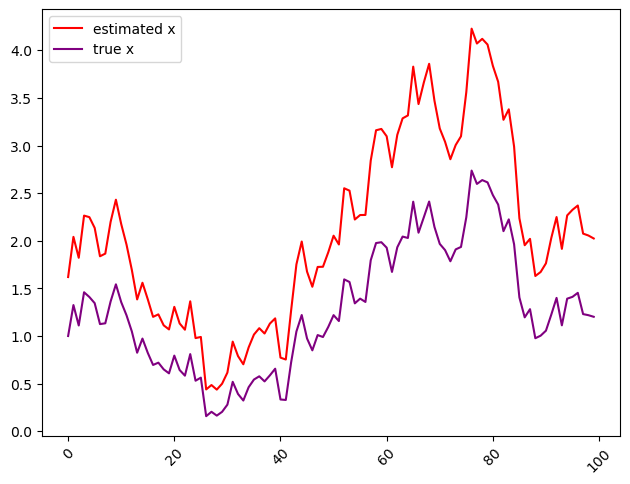

In [29]:
post_z = pm.summary(trace, var_names=["z"])["mean"].values
post_x_sd = pm.summary(trace, var_names=["z"])["sd"].values
x_lower = post_z - 1.96 * post_x_sd
x_upper = post_z + 1.96 * post_x_sd

dates = np.arange(T)
fig, ax1 = plt.subplots()
#ax1.fill_between(dates, x_lower, x_upper, color='red', alpha=0.3, label='95% CI')
line1, = ax1.plot(post_z, label='estimated x', color='red') 
line2, = ax1.plot(z_true, label='true x', color='purple') 
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()  

## ------------------------------------------------------------
## Real data

### Output gap
Beveridge-Nelson Filter (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

## ------------------------------------------------------------

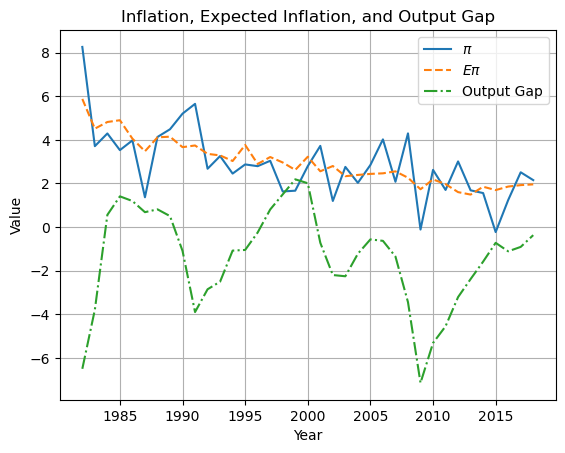

In [30]:
data_cpi = pd.read_csv("data/CPIAUCSL.csv")
data_cpi['month'] = pd.to_datetime(data_cpi['DATE']).dt.month
data_cpi = data_cpi[data_cpi['month'] == 1]
data_cpi['year'] = pd.to_datetime(data_cpi['DATE']).dt.year
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi[['year', 'pi']]

data_gap = pd.read_csv("data/BN_filter_GDPC1_annual.csv")
data_gap['year'] = pd.to_datetime(data_gap['date']).dt.year
data_gap['gap'] = data_gap["cycle"]
data_gap = data_gap[["year", "gap"]]

data_Epi = pd.read_csv("data/inflation_expectations_monthly.csv")
data_Epi['month'] = pd.to_datetime(data_Epi['DateTime']).dt.month
data_Epi = data_Epi[data_Epi['month'] == 1]
data_Epi['year'] = pd.to_datetime(data_Epi['DateTime']).dt.year
data_Epi['Epi'] = data_Epi['expected_inflation']
data_Epi = data_Epi[['year', 'Epi']]

data = pd.merge(data_gap, data_Epi, on='year', how='inner')
data = pd.merge(data, data_cpi, on='year', how='inner')
data = data[data['year'] < 2019]

# Convert each pandas Series to lists
pi = data["pi"].tolist()
Epi = data["Epi"].tolist()
gap = data["gap"].tolist()
year = data["year"].tolist()
T = len(year)


plt.plot(year, data["pi"], label=r'$\pi$', linestyle='-')       
plt.plot(year, data["Epi"], label=r'$E\pi$', linestyle='--')    
plt.plot(year, data["gap"], label='Output Gap', linestyle='-.') 

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Inflation, Expected Inflation, and Output Gap')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Define the model
with pm.Model() as model:
    # Prior distributions
    # standard errors
    sigma_kappa = pm.HalfNormal('sigma_kappa', sigma=1)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    sigma_eta = pm.HalfNormal('sigma_eta', sigma=1)
    sigma_e = pm.HalfNormal('sigma_e', sigma=1)
    
    # Parameters
    kappa = pm.Normal('kappa', mu=0, sigma=sigma_kappa)
    beta = pm.Normal('beta', mu=0, sigma=sigma_beta)
    alpha = pm.HalfNormal('alpha', sigma=sigma_alpha)

    # Latent variable
    init = pm.Normal.dist(1, size=1)
    z = pm.AR('z', 1, sigma=sigma_eta, shape=T, init_dist=init)
    # Observation model
    pi_obs = pm.Normal('pi_obs', mu=beta * Epi + kappa * gap - alpha * z, sigma=sigma_e, observed=pi)

with model:
    trace = pm.sample(draws=15000, tune=5000, chains=4, target_accept=0.9,
                      nuts_sampler='numpyro', random_seed=1234)

Compiling...
Compilation time =  0:00:01.443460
Sampling...


Compiling.. :   0%|          | 0/20000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/20000 [00:02<?, ?it/s]




Sampling time =  0:00:02.988483
Transforming variables...


Running chain 0:   5%|▌         | 1000/20000 [00:03<00:05, 3235.49it/s]

Running chain 0:  10%|█         | 2000/20000 [00:03<00:05, 3196.23it/s]

Running chain 0:  15%|█▌        | 3000/20000 [00:03<00:05, 3144.06it/s]






Running chain 0:  25%|██▌       | 5000/20000 [00:04<00:06, 2359.43it/s]

Running chain 0:  30%|███       | 6000/20000 [00:05<00:04, 2979.81it/s]

Running chain 0:  35%|███▌      | 7000/20000 [00:05<00:03, 3592.72it/s]

Running chain 0:  45%|████▌     | 9000/20000 [00:05<00:02, 4689.47it/s]


Running chain 0:  50%|█████     | 10000/20000 [00:05<00:01, 5277.27it/s]

Running chain 0:  55%|█████▌    | 11000/20000 [00:05<00:01, 5580.40it/s]

Running chain 0:  65%|██████▌   | 13000/20000 [00:06<00:01, 6227.01it/s]

Running chain 0:  70%|███████   | 14000/20000 [00:06<00:00, 6381.04it/s]

Running chain 0:  75%|███████▌  | 15000/20000 [00:06<00:00, 6691.54it/s]

Running chain 0:  80%|████████  | 16000/20000 [00:06<00:00, 6636.07it/s]

Running chain 0:  90%|█████████ | 18000

Transformation time =  0:00:22.573551


In [32]:
kappa_mean = pm.summary(trace, var_names=["kappa"])["mean"].values[0]
beta_mean  = pm.summary(trace, var_names=["beta"])["mean"].values[0]
alpha_mean = pm.summary(trace, var_names=["alpha"])["mean"].values[0]
print("Parameter Estimates:")
print(f"  kappa        : {kappa_mean:.4f}")
print(f"  beta         : {beta_mean:.4f}")
print(f"  alpha        : {alpha_mean:.4f}")

print("\nEquation with Estimated Parameters:")
equation = (
    rf"\pi_t = {beta_mean:.4f} \cdot E_t[\pi_{{t+1}}] + {kappa_mean:.4f} \cdot \hat{{Y}}_t - {alpha_mean:.4f} \cdot z_t"
)
display(Math(equation))

Parameter Estimates:
  kappa        : -0.1120
  beta         : 0.9970
  alpha        : 0.1660

Equation with Estimated Parameters:


<IPython.core.display.Math object>

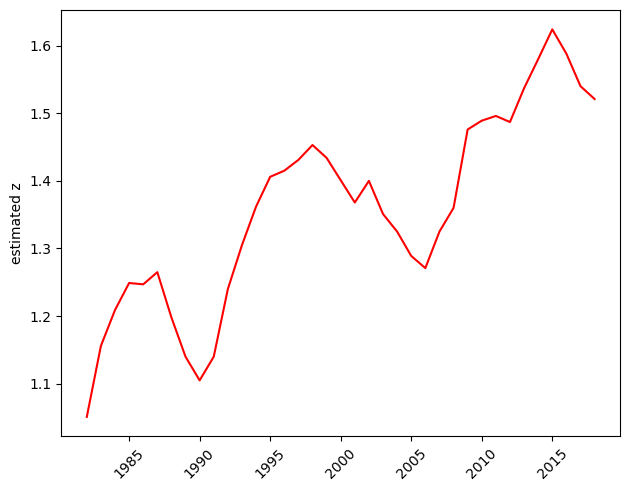

In [33]:
post_z = pm.summary(trace, var_names=["z"])["mean"].values
post_z_sd = pm.summary(trace, var_names=["z"])["sd"].values
# z_lower = post_z - 1.96 
# * post_z_sd
# z_upper = post_z + 1.96 * post_z_sd
fig, ax1 = plt.subplots()
# ax1.fill_between(year, z_lower, z_upper, color='red', alpha=0.3, label='95% CI')
line1, = ax1.plot(year,post_z, label='estimated z', color='red') 
ax1.set_ylabel('estimated z')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()  

####  Model of "COMPETITION AND THE PHILLIPS CURVE"
Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$
---
####  Estimated State-Space model

The observed variable $\pi_t$ is the inflation rate, $\text{E}\pi_t$ is the expected inflation rate, and $\text{gap}_t$ is the output gap:

---
1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho z_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
---
2. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho z_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
---
3. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho_{1} z_{t-1} +  \rho_{2} \pi_{t-1} + \rho_{3} \hat{Y}_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

---
4. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - z_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

$$
z_t =  \rho_{1} z_{t-1} +  \rho_{2} \pi_{t-1} + \rho_{3} \hat{Y}_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$